In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px 
sns.set_style('darkgrid')
from datetime import datetime
from dateutil.tz import *
import re 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from xgboost import DMatrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [23]:

data = pd.read_csv('SolarPrediction.csv')
data.info()
df=data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [24]:
#Checking if there are missing values
data.isnull().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

In [25]:
data = data.sort_values(['UNIXTime'], ascending = [True])
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
7416,1472724008,9/1/2016 12:00:00 AM,00:00:08,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00
7415,1472724310,9/1/2016 12:00:00 AM,00:05:10,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00
7414,1472725206,9/1/2016 12:00:00 AM,00:20:06,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00
7413,1472725505,9/1/2016 12:00:00 AM,00:25:05,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00
7412,1472725809,9/1/2016 12:00:00 AM,00:30:09,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00


In [26]:
from pytz import timezone
import pytz
hawaii= timezone('Pacific/Honolulu')
data.index =  pd.to_datetime(data['UNIXTime'], unit='s')
data.index = data.index.tz_localize(pytz.utc).tz_convert(hawaii)
#Step 4
data['MonthOfYear'] = data.index.strftime('%m').astype(int)
data['DayOfYear'] = data.index.strftime('%j').astype(int)
data['WeekOfYear'] = data.index.strftime('%U').astype(int)
data['TimeOfDay(h)'] = data.index.hour
data['TimeOfDay(m)'] = data.index.hour*60 + data.index.minute
data['TimeOfDay(s)'] = data.index.hour*60*60 + data.index.minute*60 + data.index.second
data['TimeSunRise'] = pd.to_datetime(data['TimeSunRise'], format='%H:%M:%S')
data['TimeSunSet'] = pd.to_datetime(data['TimeSunSet'], format='%H:%M:%S')
data['DayLength(s)'] = data['TimeSunSet'].dt.hour*60*60 \
                           + data['TimeSunSet'].dt.minute*60 \
                           + data['TimeSunSet'].dt.second \
                           - data['TimeSunRise'].dt.hour*60*60 \
                           - data['TimeSunRise'].dt.minute*60 \
                           - data['TimeSunRise'].dt.second
#Step 5
data.drop(['Data','Time','TimeSunRise','TimeSunSet'], inplace=True, axis=1)
data.head()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,MonthOfYear,DayOfYear,WeekOfYear,TimeOfDay(h),TimeOfDay(m),TimeOfDay(s),DayLength(s)
UNIXTime,,,,,,,,,,,,,,
2016-09-01 00:00:08-10:00,1472724008,2.58,51,30.43,103,77.27,11.25,9,245,35,0,0,8,45060
2016-09-01 00:05:10-10:00,1472724310,2.83,51,30.43,103,153.44,9.00,9,245,35,0,5,310,45060
2016-09-01 00:20:06-10:00,1472725206,2.16,51,30.43,103,142.04,7.87,9,245,35,0,20,1206,45060
2016-09-01 00:25:05-10:00,1472725505,2.21,51,30.43,103,144.12,18.00,9,245,35,0,25,1505,45060
2016-09-01 00:30:09-10:00,1472725809,2.25,51,30.43,103,67.42,11.25,9,245,35,0,30,1809,45060


No handles with labels found to put in legend.


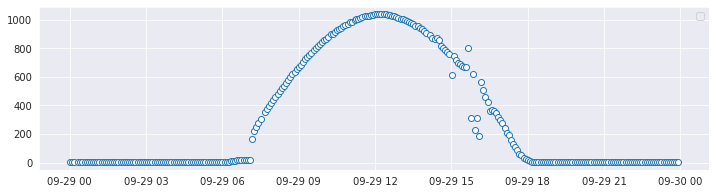

In [27]:
#Step 6
data_one_day = data.loc['2016-09-29':'2016-09-30',:]

plt.figure(figsize = (12,3))
plt.plot(data_one_day.Radiation, 'o', markerfacecolor = 'w')


#Adjusting timezone of x-axis
plt.gca().xaxis_date('HST')

plt.legend()
plt.show()

In [28]:
#Step 7

#Analysing the ranges of the various features of the datset
data.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,MonthOfYear,DayOfYear,WeekOfYear,TimeOfDay(h),TimeOfDay(m),TimeOfDay(s),DayLength(s)
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869,10.526066,306.110965,43.871015,11.557425,721.002203,43277.574068,41433.032491
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,1.096691,34.781367,4.963061,6.912034,415.011513,24900.749819,1795.873502
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000,9.000000,245.000000,35.000000,0.000000,0.000000,1.000000,39360.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000,10.000000,277.000000,40.000000,6.000000,360.000000,21617.000000,39720.000000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000,11.000000,306.000000,44.000000,12.000000,720.000000,43230.000000,41040.000000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000,11.000000,334.000000,48.000000,18.000000,1080.000000,64849.000000,42900.000000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000,12.000000,366.000000,52.000000,23.000000,1436.000000,86185.000000,45060.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/di

Text(0, 0.5, '')

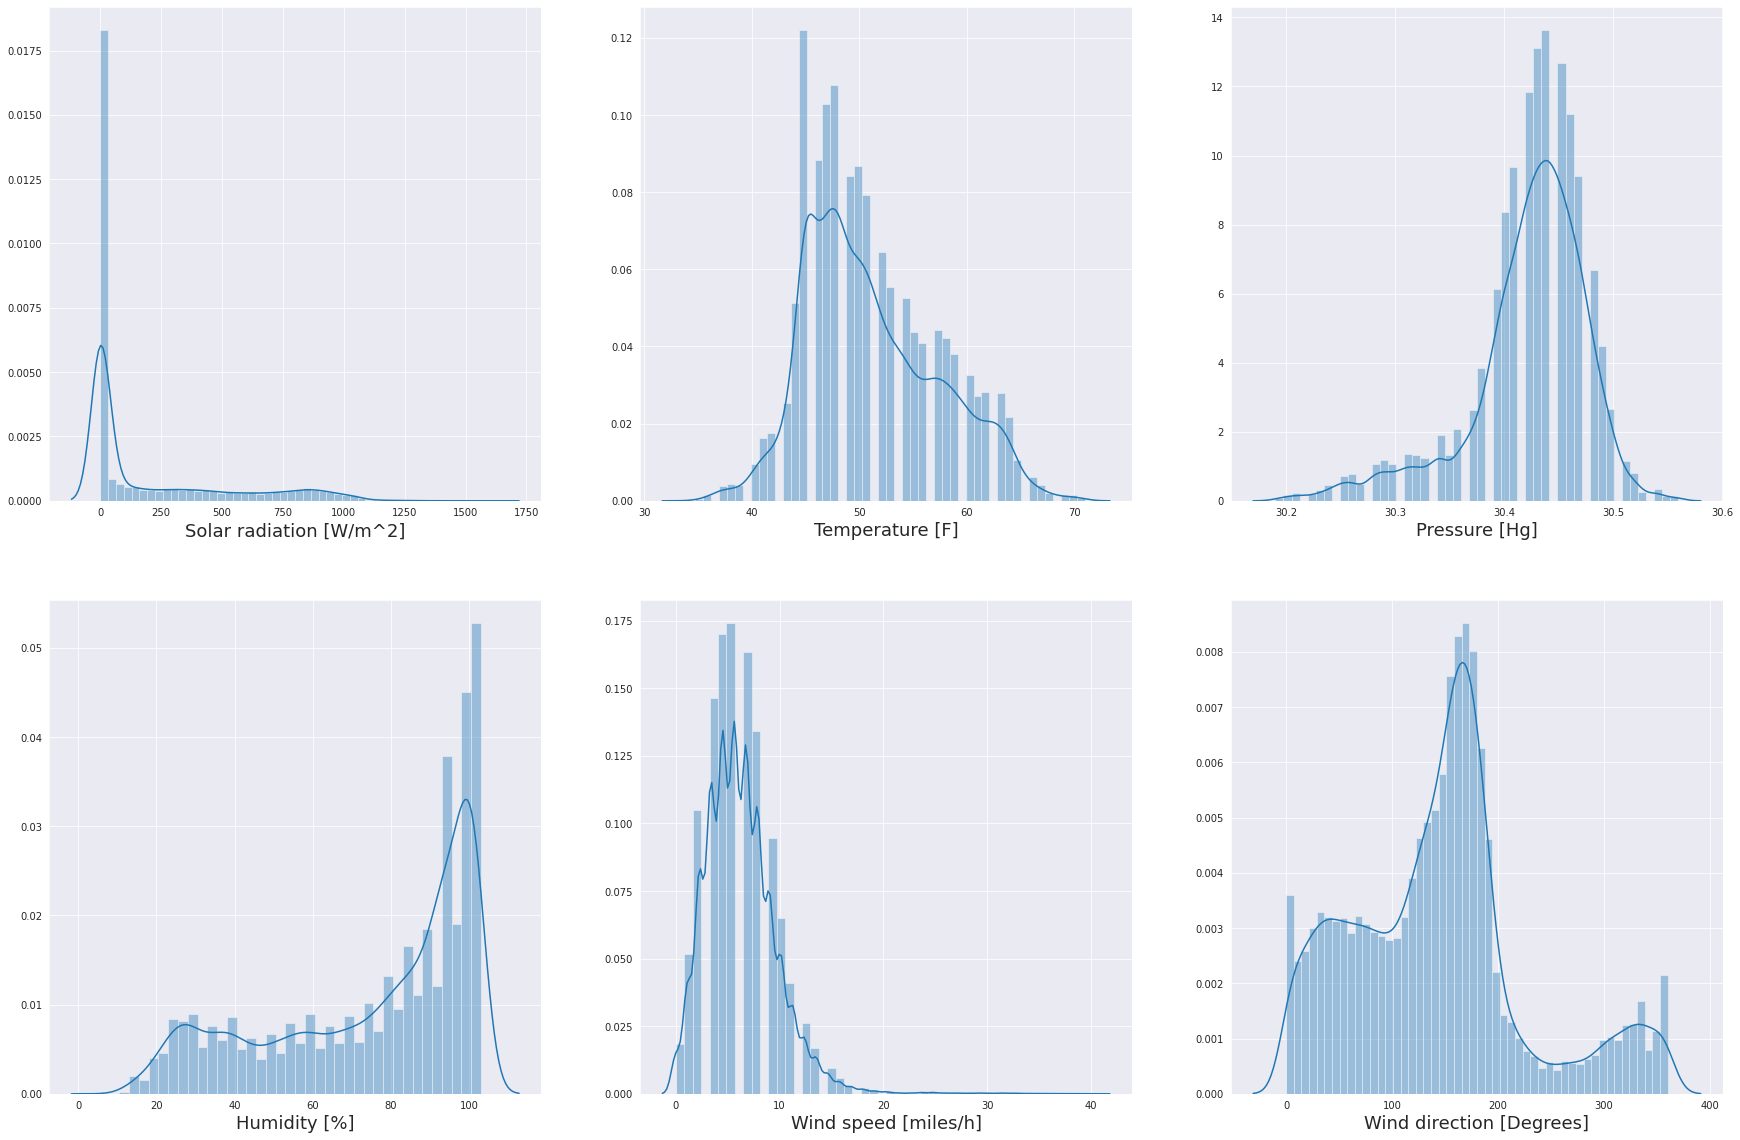

In [29]:
#Step 8
fig, ax = plt.subplots(nrows =2, ncols =3 , figsize = (30, 20))

sns.distplot(data.Radiation, ax = ax[0,0])
ax[0,0].set_xlabel('Solar radiation [W/m^2]', fontsize = 18)
ax[0,0].set_ylabel('', fontsize = 18)
sns.distplot(data.Temperature, ax = ax[0,1])
ax[0,1].set_xlabel('Temperature [F]', fontsize = 18)
ax[0,1].set_ylabel('', fontsize = 18)
sns.distplot(data.Pressure, ax = ax[0,2])
ax[0,2].set_xlabel('Pressure [Hg]', fontsize = 18)
ax[0,2].set_ylabel('', fontsize = 18)
sns.distplot(data.Humidity, ax = ax[1,0])
ax[1,0].set_xlabel('Humidity [%]', fontsize = 18)
ax[1,0].set_ylabel('', fontsize = 18)
sns.distplot(data.Speed, ax = ax[1,1])
ax[1,1].set_xlabel('Wind speed [miles/h]', fontsize = 18)
ax[1,1].set_ylabel('', fontsize = 18)
sns.distplot(data['WindDirection(Degrees)'], ax = ax[1,2])
ax[1,2].set_xlabel('Wind direction [Degrees]', fontsize = 18)
ax[1,2].set_ylabel('', fontsize = 18)

In [30]:
df['Month'] = df['Data'].apply(lambda y: re.search(r'^\d+', y).group(0))
df['Day'] = df['Data'].apply(lambda y: re.search(r'(?<=\/)\d+(?=\/)', y).group(0))
df['Year'] = df['Data'].apply(lambda y: re.search(r'(?<=\/)\d+(?=\s)', y).group(0))
df['Month'] = df['Data'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
df['Day'] = df['Data'].apply(lambda y: re.search(r'(?<=\/)\d+(?=\/)', y).group(0)).astype(np.int)
df['Year'] = df['Data'].apply(lambda y: re.search(r'(?<=\/)\d+(?=\s)', y).group(0)).astype(np.int)


In [31]:
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Year
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,2016
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,2016
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,2016
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,2016
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00,12,1,2016
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00,12,1,2016
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00,12,1,2016
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00,12,1,2016


In [32]:
df=df.drop(['Data'],axis=1)

In [33]:
df

,UNIXTime,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Year
0,1475229326,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,2016
1,1475229023,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,2016
2,1475228726,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,2016
3,1475228421,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,2016
4,1475228124,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00,12,1,2016
32682,1480587301,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00,12,1,2016
32683,1480587001,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00,12,1,2016
32684,1480586702,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00,12,1,2016


In [34]:
df['Hour'] = df['Time'].apply(lambda y: re.search(r'^\d+', y).group(0)).astype(np.int)
df['Minute'] = df['Time'].apply(lambda y: re.search(r'(?<=\:)\d+(?=\:)', y).group(0)).astype(np.int)
df['Second'] = df['Time'].apply(lambda y: re.search(r'\d+$', y).group(0)).astype(np.int)

In [35]:
del df['Time']

In [36]:
df['SunriseHour'] = df['TimeSunRise'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
df['SunriseMinute'] = df['TimeSunRise'].apply(lambda x: re.search(r'(?<=:)\d+(?=:)', x).group(0)).astype(np.int)

df['SunsetHour'] = df['TimeSunSet'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
df['SunsetMinute'] = df['TimeSunSet'].apply(lambda x: re.search(r'(?<=:)\d+(?=:)', x).group(0)).astype(np.int)

df = df.drop(['TimeSunRise', 'TimeSunSet'], axis=1)

In [37]:
df.dtypes

UNIXTime                    int64
Radiation                 float64
Temperature                 int64
Pressure                  float64
Humidity                    int64
WindDirection(Degrees)    float64
Speed                     float64
Month                       int64
Day                         int64
Year                        int64
Hour                        int64
Minute                      int64
Second                      int64
SunriseHour                 int64
SunriseMinute               int64
SunsetHour                  int64
SunsetMinute                int64
dtype: object

In [38]:
# Separating Dependent variable which is Radiation in this case from Independent variables
y = df['Radiation'].copy()
X = df.drop('Radiation', axis=1).copy()

In [39]:
scaler = StandardScaler()

Z = scaler.fit_transform(X)

In [40]:
pd.DataFrame(Z)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.937753,-0.500439,0.678974,-0.616253,0.407620,-0.178738,-1.391540,1.512248,0.0,1.655482,1.589236,0.660811,0.0,-0.943425,1.369126,-1.525765
1,-0.937854,-0.500439,0.678974,-0.654730,0.400285,-0.823359,-1.391540,1.512248,0.0,1.655482,1.299687,0.429167,0.0,-0.943425,1.369126,-1.525765
2,-0.937953,-0.500439,0.678974,-0.693206,0.183490,-0.823359,-1.391540,1.512248,0.0,1.655482,1.010138,0.660811,0.0,-0.943425,1.369126,-1.525765
3,-0.938054,-0.500439,0.678974,-0.577776,-0.069497,-0.823359,-1.391540,1.512248,0.0,1.655482,0.720589,0.274737,0.0,-0.943425,1.369126,-1.525765
4,-0.938153,-0.500439,0.678974,-0.500823,-0.463407,-0.178738,-1.391540,1.512248,0.0,1.655482,0.431040,0.506381,0.0,-0.943425,1.369126,-1.525765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,0.845373,-1.145490,0.130250,1.038241,0.023209,0.145006,1.344003,-1.701824,0.0,-1.672098,-0.437606,-1.037912,0.0,0.860876,-0.730393,0.293766
32682,0.845273,-1.145490,-0.052658,1.038241,-0.309138,0.145006,1.344003,-1.701824,0.0,-1.672098,-0.727155,-1.269556,0.0,0.860876,-0.730393,0.293766
32683,0.845173,-1.145490,-0.052658,1.038241,0.020443,0.789627,1.344003,-1.701824,0.0,-1.672098,-1.016704,-1.269556,0.0,0.860876,-0.730393,0.293766
32684,0.845073,-1.145490,-0.052658,0.999764,0.248901,0.465884,1.344003,-1.701824,0.0,-1.672098,-1.306253,-1.192341,0.0,0.860876,-0.730393,0.293766


In [41]:
df.drop(['SunriseHour'],axis=1)

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Year,Hour,Minute,Second,SunriseMinute,SunsetHour,SunsetMinute
0,1475229326,1.21,48,30.46,59,177.39,5.62,9,29,2016,23,55,26,13,18,13
1,1475229023,1.21,48,30.46,58,176.78,3.37,9,29,2016,23,50,23,13,18,13
2,1475228726,1.23,48,30.46,57,158.75,3.37,9,29,2016,23,45,26,13,18,13
3,1475228421,1.21,48,30.46,60,137.71,3.37,9,29,2016,23,40,21,13,18,13
4,1475228124,1.17,48,30.46,62,104.95,5.62,9,29,2016,23,35,24,13,18,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,1.22,44,30.43,102,145.42,6.75,12,1,2016,0,20,4,41,17,42
32682,1480587301,1.17,44,30.42,102,117.78,6.75,12,1,2016,0,15,1,41,17,42
32683,1480587001,1.20,44,30.42,102,145.19,9.00,12,1,2016,0,10,1,41,17,42
32684,1480586702,1.23,44,30.42,101,164.19,7.87,12,1,2016,0,5,2,41,17,42


In [43]:
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
kf = KFold(shuffle=True, random_state=19)

In [49]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from catboost import CatBoostRegressor

trees = {
    'linear': LinearRegression(),
    'randomfor': RandomForestRegressor(random_state=19), 
    'gradientb': GradientBoostingRegressor(random_state=19), 
    'xgb': XGBRegressor(random_state=19), 
    'xgbrf': XGBRFRegressor(random_state=19), 
    'catboost': CatBoostRegressor(random_state=19, silent=True),
    'DecisionTr': DecisionTreeRegressor(random_state=19),
    'extratre': ExtraTreesRegressor(random_state=19),
    
}

In [47]:
!pip3 install catboost

     |████████████████████████████████| 67.3MB 57kB/s 


In [61]:
scores = []
rmse=[]
mse=[]
mae=[]
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

R^2-Coefficient of Determination value 0.6335711676957615
MAE: 145.01725296845444
MSE: 36405.49405512326
RMSE: 190.80223807681938


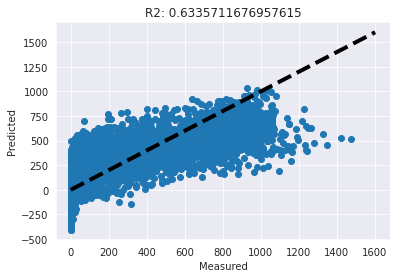

In [77]:
from sklearn import metrics 
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
predictions = regression_model.predict(X_test)
scores.append(100*regression_model.score(X_test, y_test))
rmse.append(np.sqrt(mean_squared_error(y_test, regression_model.predict(X_test))))
mse.append(metrics.mean_squared_error(y_test, predictions))
mae.append(metrics.mean_absolute_error(y_test, predictions))
print('R^2-Coefficient of Determination value',regression_model.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test, predictions)) 
print('MSE:', metrics.mean_squared_error(y_test, predictions)) 
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions))) 

fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2: ' + str(r2_score(y_test, predictions)))
plt.show()

R^2-Coefficient of Determination value 0.9397607645687598
MAE: 28.528144913568916
MSE: 5984.897841107516
RMSE: 77.362121487893


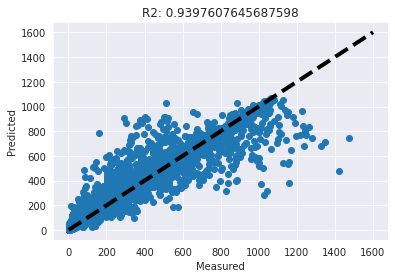

In [74]:
from sklearn import metrics 
Randomforest= RandomForestRegressor(random_state=7).fit(X_train, y_train)
scores.append(Randomforest.score(X_test, y_test))
rmse.append(np.sqrt(mean_squared_error(y_test, Randomforest.predict(X_test))))
predictions = Randomforest.predict(X_test)
mse.append(metrics.mean_squared_error(y_test, predictions))
mae.append(metrics.mean_absolute_error(y_test, predictions))
print('R^2-Coefficient of Determination value',Randomforest.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test, predictions)) 
print('MSE:', metrics.mean_squared_error(y_test, predictions)) 
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions))) 

fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2: ' + str(r2_score(y_test, predictions)))
plt.show()

R^2-Coefficient of Determination value 0.885226927681873
MAE: 57.964616727490224
MSE: 11402.952043076639
RMSE: 106.78460583378411


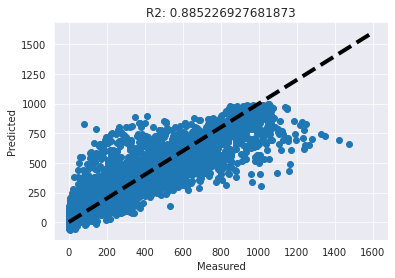

In [76]:
from sklearn import metrics 
gb = GradientBoostingRegressor(random_state=19).fit(X_train, y_train)
scores.append(gb.score(X_test, y_test))
rmse.append(np.sqrt(mean_squared_error(y_test, gb.predict(X_test))))
predictions = gb.predict(X_test)
mse.append(metrics.mean_squared_error(y_test, predictions))
mae.append(metrics.mean_absolute_error(y_test, predictions))
print('R^2-Coefficient of Determination value',gb.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test, predictions)) 
print('MSE:', metrics.mean_squared_error(y_test, predictions)) 
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions))) 

fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2: ' + str(r2_score(y_test, predictions)))
plt.show()

[10:18:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2-Coefficient of Determination value 0.8852824367676899
MAE: 58.169058761414135
MSE: 11397.437095792036
RMSE: 106.75877994709398


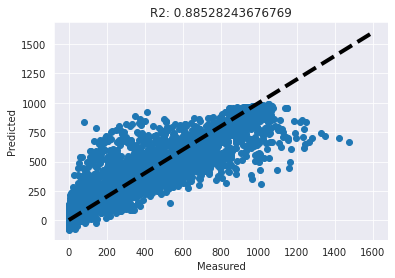

In [81]:
from sklearn import metrics 
xgb = XGBRegressor(random_state=19).fit(X_train, y_train)
scores.append(xgb.score(X_test, y_test))
rmse.append(np.sqrt(mean_squared_error(y_test, xgb.predict(X_test))))
predictions = xgb.predict(X_test)
mse.append(metrics.mean_squared_error(y_test, predictions))
mae.append(metrics.mean_absolute_error(y_test, predictions))
print('R^2-Coefficient of Determination value',xgb.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test, predictions)) 
print('MSE:', metrics.mean_squared_error(y_test, predictions)) 
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions))) 

fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2: ' + str(r2_score(y_test, predictions)))
plt.show()

[10:21:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2-Coefficient of Determination value 0.7545324491841008
MAE: 100.62725471666397
MSE: 24387.730096888776
RMSE: 156.16571357660035


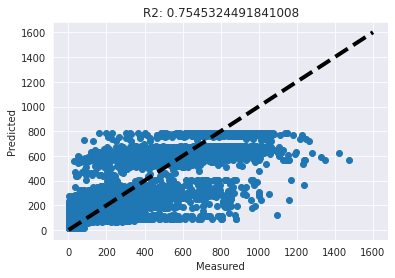

In [82]:
from sklearn import metrics 
xgbrfr = XGBRFRegressor(random_state=133).fit(X_train, y_train)
scores.append(xgbrfr.score(X_test, y_test))
rmse.append(np.sqrt(mean_squared_error(y_test, xgbrfr.predict(X_test))))
predictions = xgbrfr.predict(X_test)
mse.append(metrics.mean_squared_error(y_test, predictions))
mae.append(metrics.mean_absolute_error(y_test, predictions))
print('R^2-Coefficient of Determination value',xgbrfr.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test, predictions)) 
print('MSE:', metrics.mean_squared_error(y_test, predictions)) 
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions))) 

fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2: ' + str(r2_score(y_test, predictions)))
plt.show()

R^2-Coefficient of Determination value 0.9333507619270927
MAE: 37.63011463007001
MSE: 6621.745415565804
RMSE: 81.37410777124259


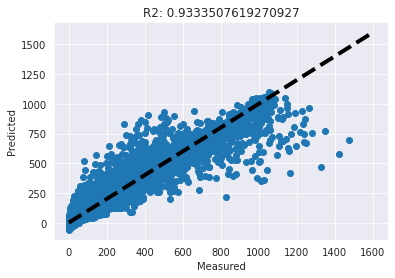

In [83]:
from sklearn import metrics 
cat= CatBoostRegressor(random_state=19, silent=True).fit(X_train, y_train)
scores.append(cat.score(X_test, y_test))
rmse.append(np.sqrt(mean_squared_error(y_test, cat.predict(X_test))))
predictions = cat.predict(X_test)
mse.append(metrics.mean_squared_error(y_test, predictions))
mae.append(metrics.mean_absolute_error(y_test, predictions))
print('R^2-Coefficient of Determination value',cat.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test, predictions)) 
print('MSE:', metrics.mean_squared_error(y_test, predictions)) 
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions))) 

fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2: ' + str(r2_score(y_test, predictions)))
plt.show()

R^2-Coefficient of Determination value 0.8920975915661509
MAE: 34.67589108153587
MSE: 10720.33678155117
RMSE: 103.53905920738883


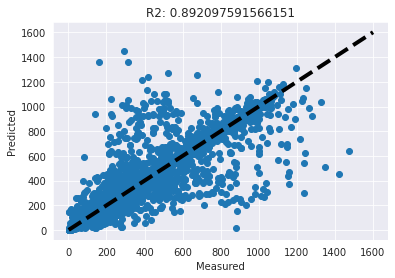

In [84]:
dt = DecisionTreeRegressor(random_state=19).fit(X_train, y_train)
from sklearn import metrics 
scores.append(dt.score(X_test, y_test))
rmse.append(np.sqrt(mean_squared_error(y_test, dt.predict(X_test))))
predictions = dt.predict(X_test)
mse.append(metrics.mean_squared_error(y_test, predictions))
mae.append(metrics.mean_absolute_error(y_test, predictions))
print('R^2-Coefficient of Determination value',dt.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test, predictions)) 
print('MSE:', metrics.mean_squared_error(y_test, predictions)) 
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions))) 

fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2: ' + str(r2_score(y_test, predictions)))
plt.show()


R^2-Coefficient of Determination value 0.9377876919942867
MAE: 28.468377497322926
MSE: 6180.926852876636
RMSE: 78.61887084457926


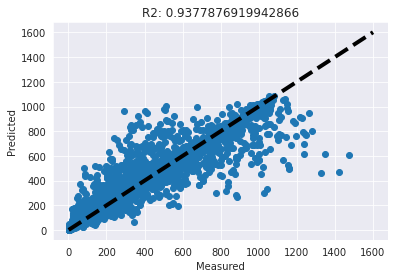

In [86]:
et = ExtraTreesRegressor(random_state=19).fit(X_train, y_train)
from sklearn import metrics 
scores.append(et.score(X_test, y_test))
rmse.append(np.sqrt(mean_squared_error(y_test, et.predict(X_test))))
predictions = et.predict(X_test)
mse.append(metrics.mean_squared_error(y_test, predictions))
mae.append(metrics.mean_absolute_error(y_test, predictions))
print('R^2-Coefficient of Determination value',et.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test, predictions)) 
print('MSE:', metrics.mean_squared_error(y_test, predictions)) 
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions))) 

fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2: ' + str(r2_score(y_test, predictions)))
plt.show()